In [1]:
import sys
sys.path.append("../") # go to parent dir
import matplotlib.pyplot as plt
from matplotlib import cm
from lib.graph import grid_tensor
from torch_geometric.nn import graclus, voxel_grid, max_pool
import torch
from torch_geometric.utils import normalized_cut
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.data import Data
import numpy as np

from torch_geometric.nn import knn_interpolate, SplineConv, max_pool_x,  global_mean_pool

from torch.nn import Sequential as Seq, Linear as Lin, ReLU, BatchNorm1d as BN
from torch_geometric.nn import PointConv, fps, radius

from lib.datasets import MNIST


# Grid tensor function
**Grid Tensor** is a function to create graph representation of grid. In this case we fill out the values with the 25 ascending values to test the clustering (pooling) and the recomposition of the structures. Later this is used to contruct the pooling and unpooling layers in our version of the FCN using the graph convolutions. The network is writen over the examples in the library **pytorch_geometric**

In [2]:
grid = grid_tensor((5,5),connectivity=4)
values = np.linspace(0,1,25)
print(values)
grid.x = torch.linspace(0,1,25)
print(grid)

[0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.        ]
Data(edge_index=[2, 80], pos=[25, 2], x=[25], y=[1])


## Auxiliar functions for graph-grid

**Normalized cud 2d** computes the euclidean distances between nodes in a graph expressed in a list of adjacent members.

In [3]:

def normalized_cut_2d(edge_index, pos):
    row, col = edge_index
    edge_attr = torch.norm(pos[row] - pos[col], p=2, dim=1)
    return normalized_cut(edge_index, edge_attr, num_nodes=pos.size(0))


In [4]:
def plot_tensor(d):
    d = d
    plt.figure()
    plt.gca().invert_yaxis()
#     plt.yticks(rotation=90)
    pos_x = d.pos[:,0].numpy()
    pos_y = d.pos[:,1].numpy()
    values =  d.x[:].detach().numpy()
    coo_matrix = d.edge_index 
    colors = [cm.spring(color) for color in values]
    for i in range(d.num_edges):
        ii, jj = coo_matrix[0,i], coo_matrix[1,i]
        plt.plot([pos_y[ii],pos_y[jj]],[pos_x[ii],pos_x[jj]],'k-',alpha=0.1)
    for xx, yy, cc in zip(pos_x, pos_y, colors):
        plt.plot(yy, xx, 'o', color=cc)

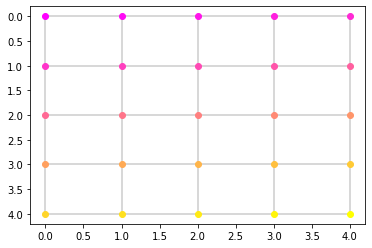

In [5]:
plot_tensor(grid)

In [6]:
transform=T.Cartesian()

In [7]:
a = transform(grid)

In [8]:
grid

Data(edge_attr=[80, 2], edge_index=[2, 80], pos=[25, 2], x=[25], y=[1])

## Cluster grid

Calculates the clustering and maxpools the features attached to the nodes to form a secondary graph that is the compressed version of the first. The new nodes positions are the centroids of the clusters formed.

In [9]:
def cluster_grid(grid):
    data = grid
    # data.x = conv1(data.x, data.edge_index, data.edge_attr)
    weight = normalized_cut_2d(data.edge_index, data.pos)
    cluster = graclus(data.edge_index, weight, data.x.size(0))
    data.edge_attr = None
    data.batch = None
    data = max_pool(cluster, data, transform=T.Cartesian(cat=False))
    return data, cluster

data, cluster = cluster_grid(grid)

In [10]:
print(cluster)
# print(grid.pos[0:2][0:2])

tensor([ 0,  1,  2,  2,  4,  0,  1,  7,  8,  4, 10, 10,  7, 13, 13, 15, 16, 17,
        18, 19, 15, 16, 17, 18, 19])


data:  Batch(edge_attr=[46, 2], edge_index=[2, 46], pos=[13, 2], x=[13])
position values:  tensor([[0.5000, 0.0000],
        [0.5000, 1.0000],
        [0.0000, 2.5000],
        [0.5000, 4.0000],
        [1.5000, 2.0000],
        [1.0000, 3.0000],
        [2.0000, 0.5000],
        [2.0000, 3.5000],
        [3.5000, 0.0000],
        [3.5000, 1.0000],
        [3.5000, 2.0000],
        [3.5000, 3.0000],
        [3.5000, 4.0000]])
features values:  torch.Size([13])
number of node:  13


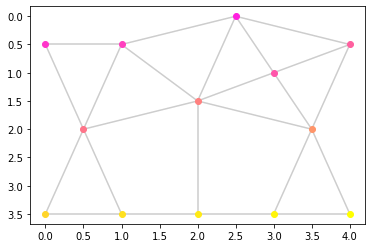

In [11]:
plot_tensor(data)
print('data: ', data)
print('position values: ', data.pos)
print('features values: ',data.x.size())
print('number of node: ',data.num_nodes)

## Recover grid function:
It is the upsampling layer function that recontructs the form of the initial graph. However because the values are computed by an uninvertible function as it is max pool the graph it's not the same and the values are just propagated in the members of the former clusters.

In [12]:
def consecutive_cluster(src):
    unique, inv = torch.unique(src, sorted=True, return_inverse=True)
    perm = torch.arange(inv.size(0), dtype=inv.dtype, device=inv.device)
    perm = inv.new_empty(unique.size(0)).scatter_(0, inv, perm)
    return inv, perm

In [13]:
def recover_grid(source, pos, edge_index, cluster, transform=None):
    cluster, perm = consecutive_cluster(cluster)
    weights = torch.ones((1,len(cluster)))
    Q = torch.zeros((source.num_nodes,cluster.shape[0])).scatter_(0,cluster.unsqueeze(0),weights)
#     print('x.shape, Q.shape',source.x.shape, Q.shape)
    
    if source.x.dim()==1:
        x = source.x.unsqueeze(0).mm(Q).squeeze()
    else:
        # the max dimension is 2
        x= Q.transpose(0,1).mm(source.x)
#     print('x.shape: ',x.shape)
    data = Data(x=x,edge_index=edge_index,pos=pos)
    if transform is not None:
        data = transform(data)
    return data


...recovering grid (upsampling)
grid 1     :  Data(edge_index=[2, 80], pos=[25, 2], x=[25], y=[1])
grid pool  :  Batch(edge_attr=[46, 2], edge_index=[2, 46], pos=[13, 2], x=[13])
grid unpool:  Data(edge_index=[2, 80], pos=[25, 2], x=[25])


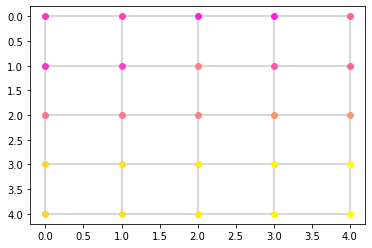

In [14]:
print('...recovering grid (upsampling)')
print('grid 1     : ', grid)
print('grid pool  : ', data)

grid_recovered = recover_grid(data, pos=grid.pos, edge_index=grid.edge_index, cluster=cluster)

print('grid unpool: ',grid_recovered)

plot_tensor(grid_recovered)

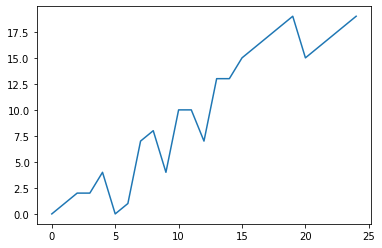

In [15]:
plt.plot(cluster.numpy())

In [16]:
cluster.unique()

tensor([ 0,  1,  2,  4,  7,  8, 10, 13, 15, 16, 17, 18, 19])

## Mnist dataset pool and unpool

First we tried to test the network can segment at least one sample and we trained to overfit on the value 7 from the MNIST dataset. The resulst were good but not definitive, so we trained later over 10 numbers as a verification test to tell whether the model makes scence. However here we can still see how the pooling and unpooling works with an untransformed sample represented in a graph grid.

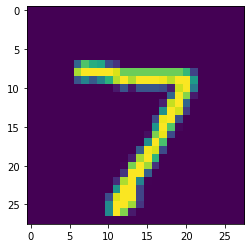

In [43]:
label = 7
number = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
                   ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
                   ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                   0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
                   ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
                   ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                   0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,84,185,159,151,60,36,0,0,0,
                   0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,222,254,254,254,254,241,
                   198,198,198,198,198,198,198,198,170,52,0,0,0,0,0,0,0,0,0,0,0,0,67,
                   114,72,114,163,227,254,225,254,254,254,250,229,254,254,140,0,0,0,0,
                   0,0,0,0,0,0,0,0,0,0,0,0,0,17,66,14,67,67,67,59,21,236,254,106,0,0,0,
                   0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,83,253,209,18,0,0,0,0,0,0,
                   0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,233,255,83,0,0,0,0,0,0,0,0,0,0,
                   0,0,0,0,0,0,0,0,0,0,0,0,0,0,129,254,238,44,0,0,0,0,0,0,0,0,0,0,0,0,0,
                   0,0,0,0,0,0,0,0,0,0,59,249,254,62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                   0,0,0,0,0,0,133,254,187,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                   0,9,205,248,58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,126,254,
                   182,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,75,251,240,57,0,0,0,
                   0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,221,254,166,0,0,0,0,0,0,0,0,0,
                   0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,203,254,219,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                   0,0,0,0,0,0,0,0,0,38,254,254,77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                   0,0,31,224,254,115,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,133,254,
                   254,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61,242,254,254,52,0,0,
                   0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,254,254,219,40,0,0,0,0,0,0,0,0,
                   0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,254,207,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                   0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])/255.0
plt.imshow(number.reshape(28,28))

In [44]:
grid = grid_tensor((28,28),connectivity=4)
grid.x = torch.tensor(number.T).float()
print(grid)

Data(edge_index=[2, 3024], pos=[784, 2], x=[784], y=[1])


In [45]:
data, cluster = cluster_grid(grid)

...recovering grid (upsampling)
grid 1     :  Data(edge_index=[2, 3024], pos=[784, 2], x=[784], y=[1])
grid pool  :  Batch(edge_attr=[2012, 2], edge_index=[2, 2012], pos=[422, 2], x=[422])
grid unpool:  Data(edge_index=[2, 3024], pos=[784, 2], x=[784])


Text(0.5, 1.0, 'seven pooled')

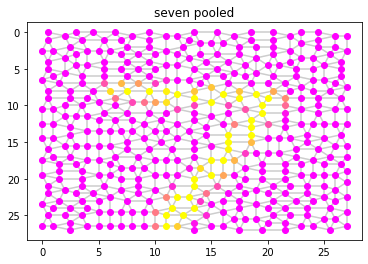

In [47]:
print('...recovering grid (upsampling)')
print('grid 1     : ', grid)
print('grid pool  : ', data)

grid_recovered = recover_grid(data, pos=grid.pos, edge_index=grid.edge_index, cluster=cluster)

print('grid unpool: ',grid_recovered)
plot_tensor(data)
plt.title('seven pooled')

Text(0.5, 1.0, 'seven recovered')

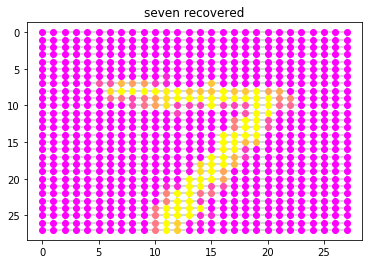

In [48]:
plot_tensor(grid_recovered)
plt.title('seven recovered')


Text(0.5, 1.0, 'seven original')

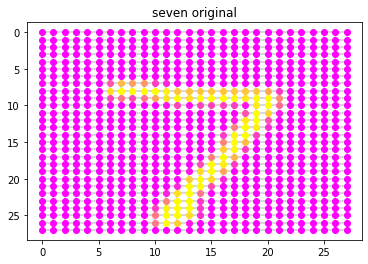

In [49]:
plot_tensor(grid)
plt.title('seven original')# plt.title('seven original')

## Network training 

the network is composed by 4 convolutions, 2 poolings and 2 unpoolings. The dataloader loads the numbers 0 to 9 from the dataset. We trained over 10 times, which means 100 train iterations. To verify the network we compute the mask taking the $p(y=foreground|x)>0.5$ threshold from the sample **123** from the same dataset which corresponds to the letter **6**.

In [22]:
class DataLoader_seven(object):
    
    def __init__(self):
        ## make the 7
        self.label = 7
        self.number = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
                           ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
                           ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                           0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
                           ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
                           ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                           0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,84,185,159,151,60,36,0,0,0,
                           0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,222,254,254,254,254,241,
                           198,198,198,198,198,198,198,198,170,52,0,0,0,0,0,0,0,0,0,0,0,0,67,
                           114,72,114,163,227,254,225,254,254,254,250,229,254,254,140,0,0,0,0,
                           0,0,0,0,0,0,0,0,0,0,0,0,0,17,66,14,67,67,67,59,21,236,254,106,0,0,0,
                           0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,83,253,209,18,0,0,0,0,0,0,
                           0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,233,255,83,0,0,0,0,0,0,0,0,0,0,
                           0,0,0,0,0,0,0,0,0,0,0,0,0,0,129,254,238,44,0,0,0,0,0,0,0,0,0,0,0,0,0,
                           0,0,0,0,0,0,0,0,0,0,59,249,254,62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                           0,0,0,0,0,0,133,254,187,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                           0,9,205,248,58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,126,254,
                           182,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,75,251,240,57,0,0,0,
                           0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,221,254,166,0,0,0,0,0,0,0,0,0,
                           0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,203,254,219,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                           0,0,0,0,0,0,0,0,0,38,254,254,77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                           0,0,31,224,254,115,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,133,254,
                           254,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61,242,254,254,52,0,0,
                           0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,254,254,219,40,0,0,0,0,0,0,0,0,
                           0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,254,207,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                           0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])/255.0
        self.mask = (self.number>0.2)
    
    def __len__(self):
        return 10
    
    def __getitem__(self,idx):
        grid = grid_tensor((28,28),connectivity=4)
        grid.x = torch.tensor(self.number.T).float()
        grid.batch = torch.zeros(grid.num_nodes).long()
        grid = transform(grid)
        grid.y = torch.tensor([self.mask]).float().transpose(0,1)
        return grid
    
    def __iter__(self):
        for i in range(10):
            grid = self.__getitem__(i)
            yield grid

In [23]:
class DataLoader(object):
    def __init__(self):
        self.dataset = MNIST()
        self.test_dataset = self.dataset.train
        self.train_dataset = self.dataset.test

    def __len__(self):
        return 10
    
    def __getitem__(self,idx):
        image, mask = self.train_dataset[idx]
        grid = grid_tensor((28,28),connectivity=4)
        grid.x = torch.tensor(image.reshape(28*28)).float()
        grid.batch = torch.zeros(grid.num_nodes).long()
        grid = transform(grid)
        grid.y = torch.tensor([mask.reshape(28*28)]).float().transpose(0,1)
        return grid
    
    def __iter__(self):
        for i in range(10):
            grid = self.__getitem__(i)
            yield grid

In [24]:
dataloader = DataLoader()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/M2NIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/M2NIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/M2NIST/t10k-images-idx3-ubyte.gz
Extracting data/M2NIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


data @  0  :  Data(batch=[784], edge_attr=[3024, 2], edge_index=[2, 3024], pos=[784, 2], x=[784], y=[784, 1])
data @  1  :  Data(batch=[784], edge_attr=[3024, 2], edge_index=[2, 3024], pos=[784, 2], x=[784], y=[784, 1])
data @  2  :  Data(batch=[784], edge_attr=[3024, 2], edge_index=[2, 3024], pos=[784, 2], x=[784], y=[784, 1])
data @  3  :  Data(batch=[784], edge_attr=[3024, 2], edge_index=[2, 3024], pos=[784, 2], x=[784], y=[784, 1])
data @  4  :  Data(batch=[784], edge_attr=[3024, 2], edge_index=[2, 3024], pos=[784, 2], x=[784], y=[784, 1])
data @  5  :  Data(batch=[784], edge_attr=[3024, 2], edge_index=[2, 3024], pos=[784, 2], x=[784], y=[784, 1])
data @  6  :  Data(batch=[784], edge_attr=[3024, 2], edge_index=[2, 3024], pos=[784, 2], x=[784], y=[784, 1])
data @  7  :  Data(batch=[784], edge_attr=[3024, 2], edge_index=[2, 3024], pos=[784, 2], x=[784], y=[784, 1])
data @  8  :  Data(batch=[784], edge_attr=[3024, 2], edge_index=[2, 3024], pos=[784, 2], x=[784], y=[784, 1])
data @  9 

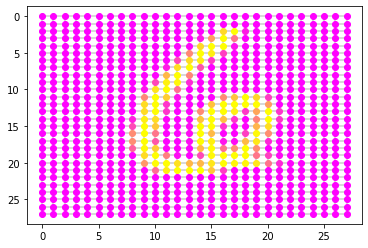

In [25]:
data = dataloader[123]
plot_tensor(data)
for i, d in enumerate(dataloader):
    print('data @ ' , i , ' : ', data)


In [26]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = SplineConv(1, 32, dim=2, kernel_size=5)
        self.conv2 = SplineConv(32, 64, dim=2, kernel_size=5)
        self.conv3 = SplineConv(64, 32, dim=2, kernel_size=5)
        self.conv4 = SplineConv(32, 1, dim=2, kernel_size=5)


    def forward(self, data):
        data.x = F.elu(self.conv1(data.x, data.edge_index, data.edge_attr))
        weight = normalized_cut_2d(data.edge_index, data.pos)
        cluster1 = graclus(data.edge_index, weight, data.x.size(0))
        pos1 = data.pos
        edge_index1 = data.edge_index
        data = max_pool(cluster1, data, transform=T.Cartesian(cat=False))

        data.x = F.elu(self.conv2(data.x, data.edge_index, data.edge_attr))
        weight = normalized_cut_2d(data.edge_index, data.pos)
        pos2 = data.pos
        edge_index2 = data.edge_index
        cluster2 = graclus(data.edge_index, weight, data.x.size(0))
        data = max_pool(cluster2, data, transform=T.Cartesian(cat=False))

        # upsample
        data = recover_grid(data, pos2, edge_index2, cluster2, transform=T.Cartesian(cat=False))
        data.x = F.elu(self.conv3(data.x, data.edge_index, data.edge_attr))
        
        data = recover_grid(data, pos1, edge_index1, cluster1, transform=T.Cartesian(cat=False))
        data.x = F.elu(self.conv4(data.x, data.edge_index, data.edge_attr))
        
        x, batch = data.x, torch.zeros(data.num_nodes)
        
        return F.sigmoid(x)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCELoss()

In [28]:
dataloader = DataLoader()

Extracting data/M2NIST/train-images-idx3-ubyte.gz
Extracting data/M2NIST/train-labels-idx1-ubyte.gz
Extracting data/M2NIST/t10k-images-idx3-ubyte.gz
Extracting data/M2NIST/t10k-labels-idx1-ubyte.gz


In [29]:
model.train()
for i in range(10):
    print('epoch', i+1)
    loss_total = 0
    for d in dataloader:
    #     print(d)
        pred = model(d)
        optimizer.zero_grad()
        loss = criterion(pred, d.y)
        loss.backward()
        optimizer.step()
        loss_val = loss.item()
        print('loss value', loss_val)
        loss_total+=loss_val
    print('==> avg. loss:', loss_total/len(dataloader))

epoch 1


/home/ari/miniconda3/envs/th/lib/python3.7/site-packages/torch_geometric/nn/conv/spline_conv.py:103: UserWarning: We do not recommend using the non-optimized CPU version of SplineConv. If possible, please convert your data to the GPU first.
  warnings.warn('We do not recommend using the non-optimized CPU '
/home/ari/miniconda3/envs/th/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss value 0.7034540772438049
loss value 0.6846123337745667
loss value 0.6101781725883484
loss value 0.5899184346199036
loss value 0.48543843626976013
loss value 0.4191931486129761
loss value 0.4643944799900055
loss value 0.454520046710968
loss value 0.5142413973808289
loss value 0.5145936608314514
==> avg. loss: 0.5440544188022614
epoch 2
loss value 0.44717252254486084
loss value 0.49819403886795044
loss value 0.3859662711620331
loss value 0.5504852533340454
loss value 0.4484665095806122
loss value 0.4063747525215149
loss value 0.46377286314964294
loss value 0.45484378933906555
loss value 0.5147899985313416
loss value 0.5147905349731445
==> avg. loss: 0.46848565340042114
epoch 3
loss value 0.4471912682056427
loss value 0.49821171164512634
loss value 0.38596677780151367
loss value 0.550474226474762
loss value 0.44846677780151367
loss value 0.4063749611377716
loss value 0.4637729227542877
loss value 0.45484432578086853
loss value 0.5147313475608826
loss value 0.5147898197174072
==> avg.

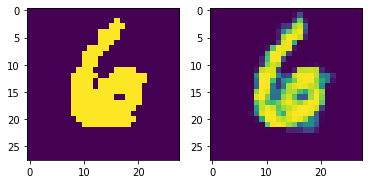

In [38]:
model.eval()
d=dataloader[123]
pred = model(d)
pred_mask = (pred > 0.5).float()
plt.subplot(1,2,1)
plt.imshow(pred_mask.detach().numpy().reshape(28,28))
plt.subplot(1,2,2)
plt.imshow(pred.detach().numpy().reshape(28,28))


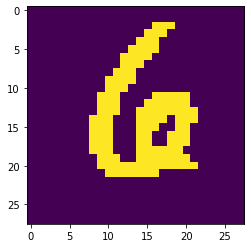

In [36]:
plt.imshow(d.y.detach().numpy().reshape(28,28))

In [37]:
torch.save(model.state_dict(),'./model.pth')

In [ ]:
# model = Net()
# model.load_state_dict(torch.load('./model.pth'))
# model.eval()
# pred = model(d)
# pred_mask = (pred > 0.5).float()
# plt.imshow(pred.detach().numpy().reshape(28,28))